## Importing Required Libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score
from matplotlib.image import imread
from keras.models import load_model
from keras.preprocessing import image
np.random.seed(42)

from matplotlib import style
# style.use('fivethirtyeight')

## Assigning Path for Dataset

In [3]:
data_dir = '/content/drive/MyDrive/DEEP/classification_data_new'
train_path = '/content/drive/MyDrive/DEEP/classification_data_new/train'
test_path = '/content/drive/MyDrive/DEEP/classification_data_new/test/'

# Resizing the images to 30x30x3
IMG_HEIGHT = 90
IMG_WIDTH = 90
channels = 3

## Finding Total Classes - Information

In [4]:
%%time
classes_folder = os.listdir(train_path)
num_class = len(classes_folder)
print(classes_folder)

['0', '1']
CPU times: user 922 µs, sys: 1.02 ms, total: 1.95 ms
Wall time: 3.91 ms


In [5]:
NUM_CATEGORIES = len(os.listdir(train_path))
print("Number of classes:",NUM_CATEGORIES)

Number of classes: 2


In [6]:
sum_image = 0
count_image = []
for i in range(num_class):
    path_to_FI = train_path + "/" + str(classes_folder[i])
    count_to_FI = os.listdir(path_to_FI)
    count_image.append(len(count_to_FI))
for i in count_image:
    sum_image = sum_image + int(i)
print("Total images to train: ",sum_image)

Total images to train:  3052


In [9]:
num_image = len(os.listdir(test_path))
print("Number of images used for testing: ",num_image)

Number of images used for testing:  400


In [10]:
# Label Overview
classes = { 0:'good',
            1:'error'}

## Visualizing The Dataset

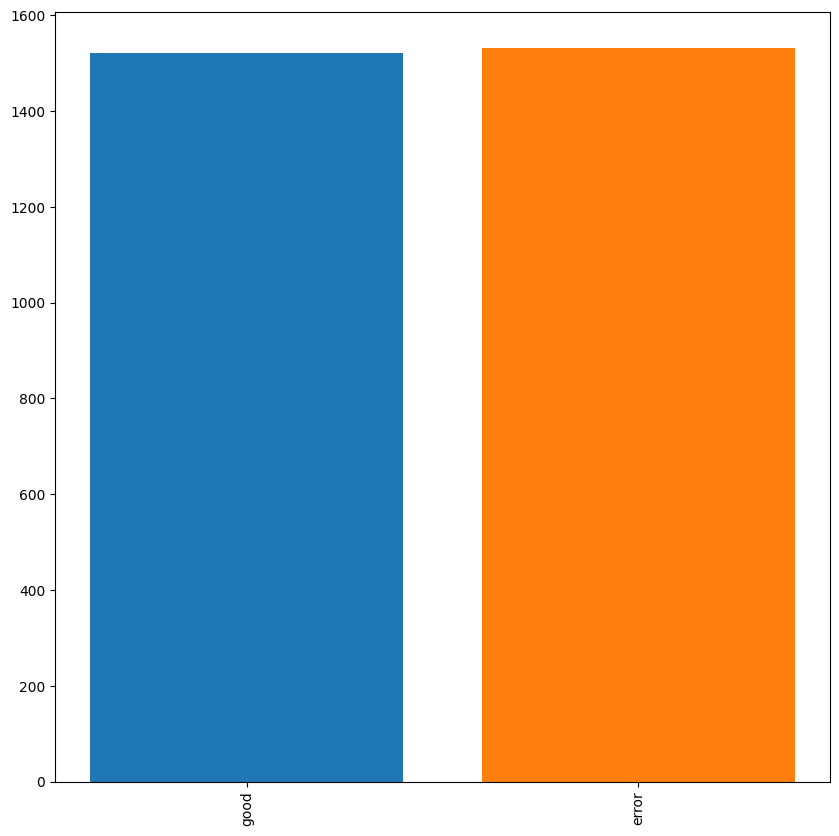

In [11]:
folders = os.listdir(train_path)

train_number = []
class_num = []

for folder in folders:
    train_files = os.listdir(train_path + '/' + folder)
    train_number.append(len(train_files))
    class_num.append(classes[int(folder)])

# Sorting the dataset on the basis of number of images in each class
zipped_lists = zip(train_number, class_num)
sorted_pairs = sorted(zipped_lists)
tuples = zip(*sorted_pairs)
train_number, class_num = [ list(tuple) for tuple in  tuples]

# Plotting the number of images in each class
plt.figure(figsize=(10,10))
for i in range(len(classes)):
    plt.bar(class_num[i],train_number[i])
plt.xticks(class_num, rotation='vertical')
plt.show()

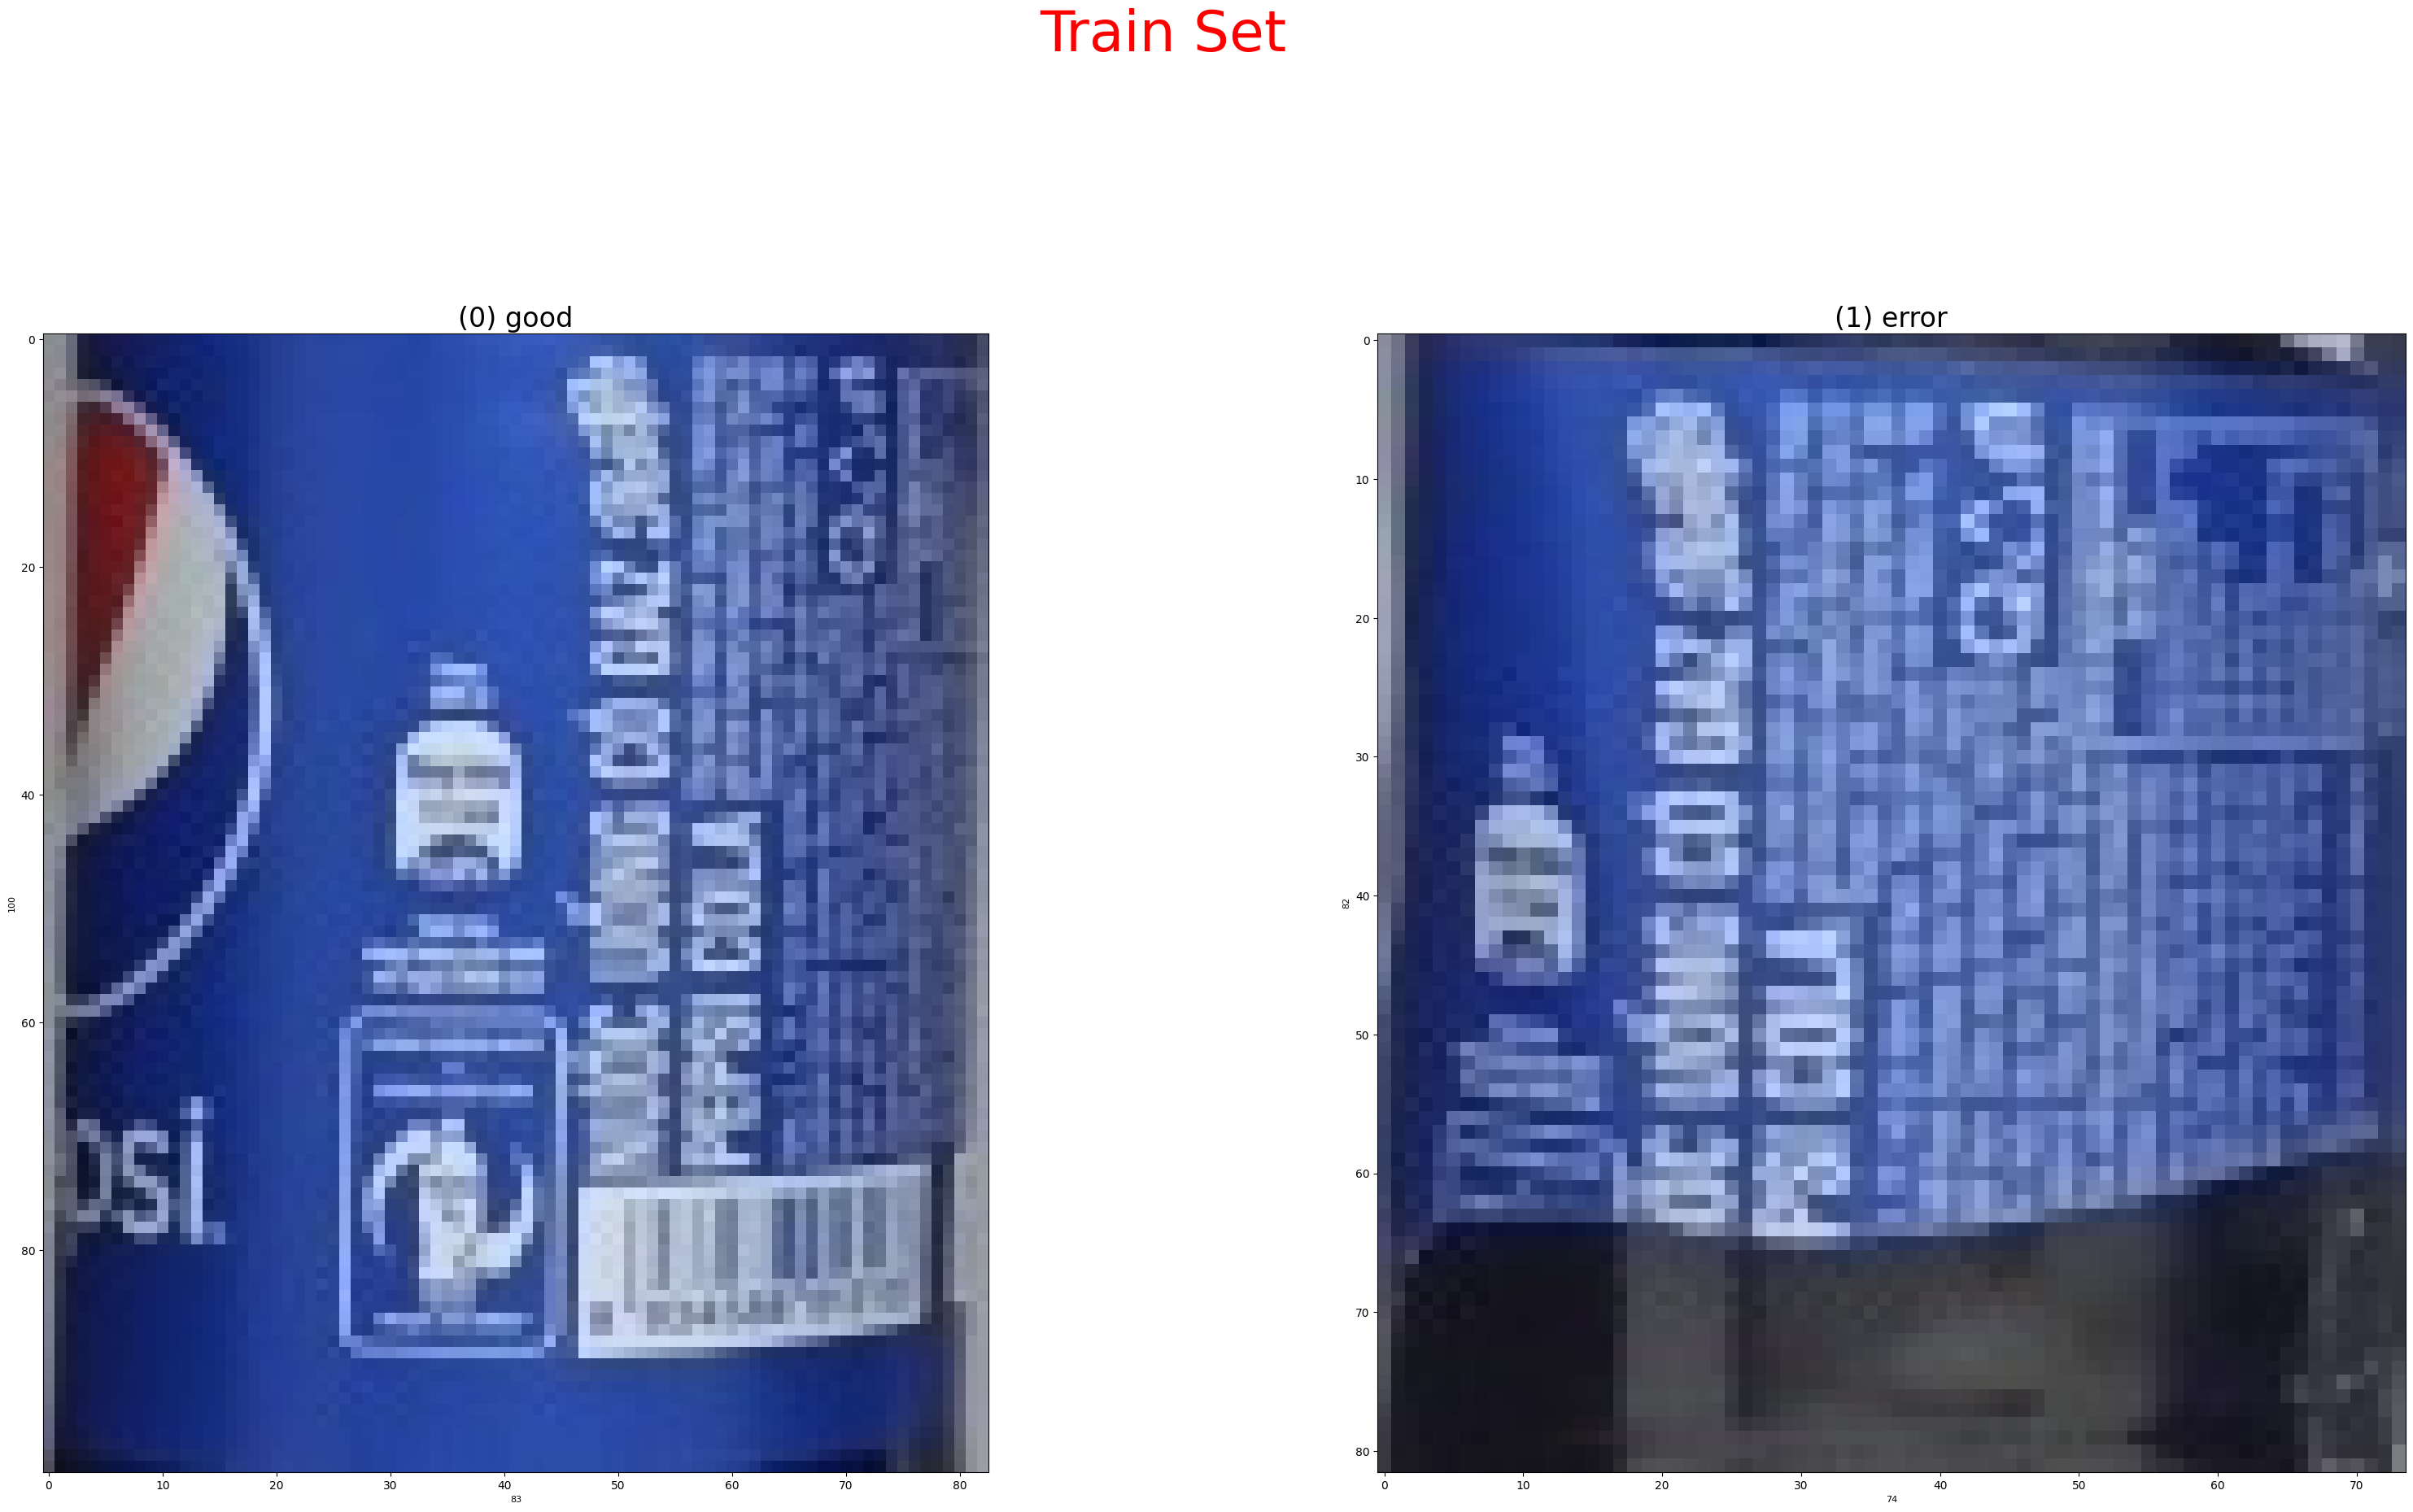

In [14]:
# Visualizing 25 images from (image index = x) in train data (folder: "0","1","2",...)

plt.figure(figsize=(40,40))
index = 50  #(image index = x)
plt.suptitle("Train Set", fontsize=50,color='red')

for i in range(1,3):
    plt.subplot(2,2,i)
    path = train_path +"/"+str(i-1)+"/"
    img = os.listdir(path)[index]
    read_img = imread(os.path.join(path,img))
    plt.title("("+str(i-1)+") "+list(classes.items())[i-1][1],fontsize=24)
    plt.xlabel(read_img.shape[1], fontsize = 8)#width of image
    plt.ylabel(read_img.shape[0], fontsize = 8)#height of image
    plt.imshow(read_img)
plt.show()

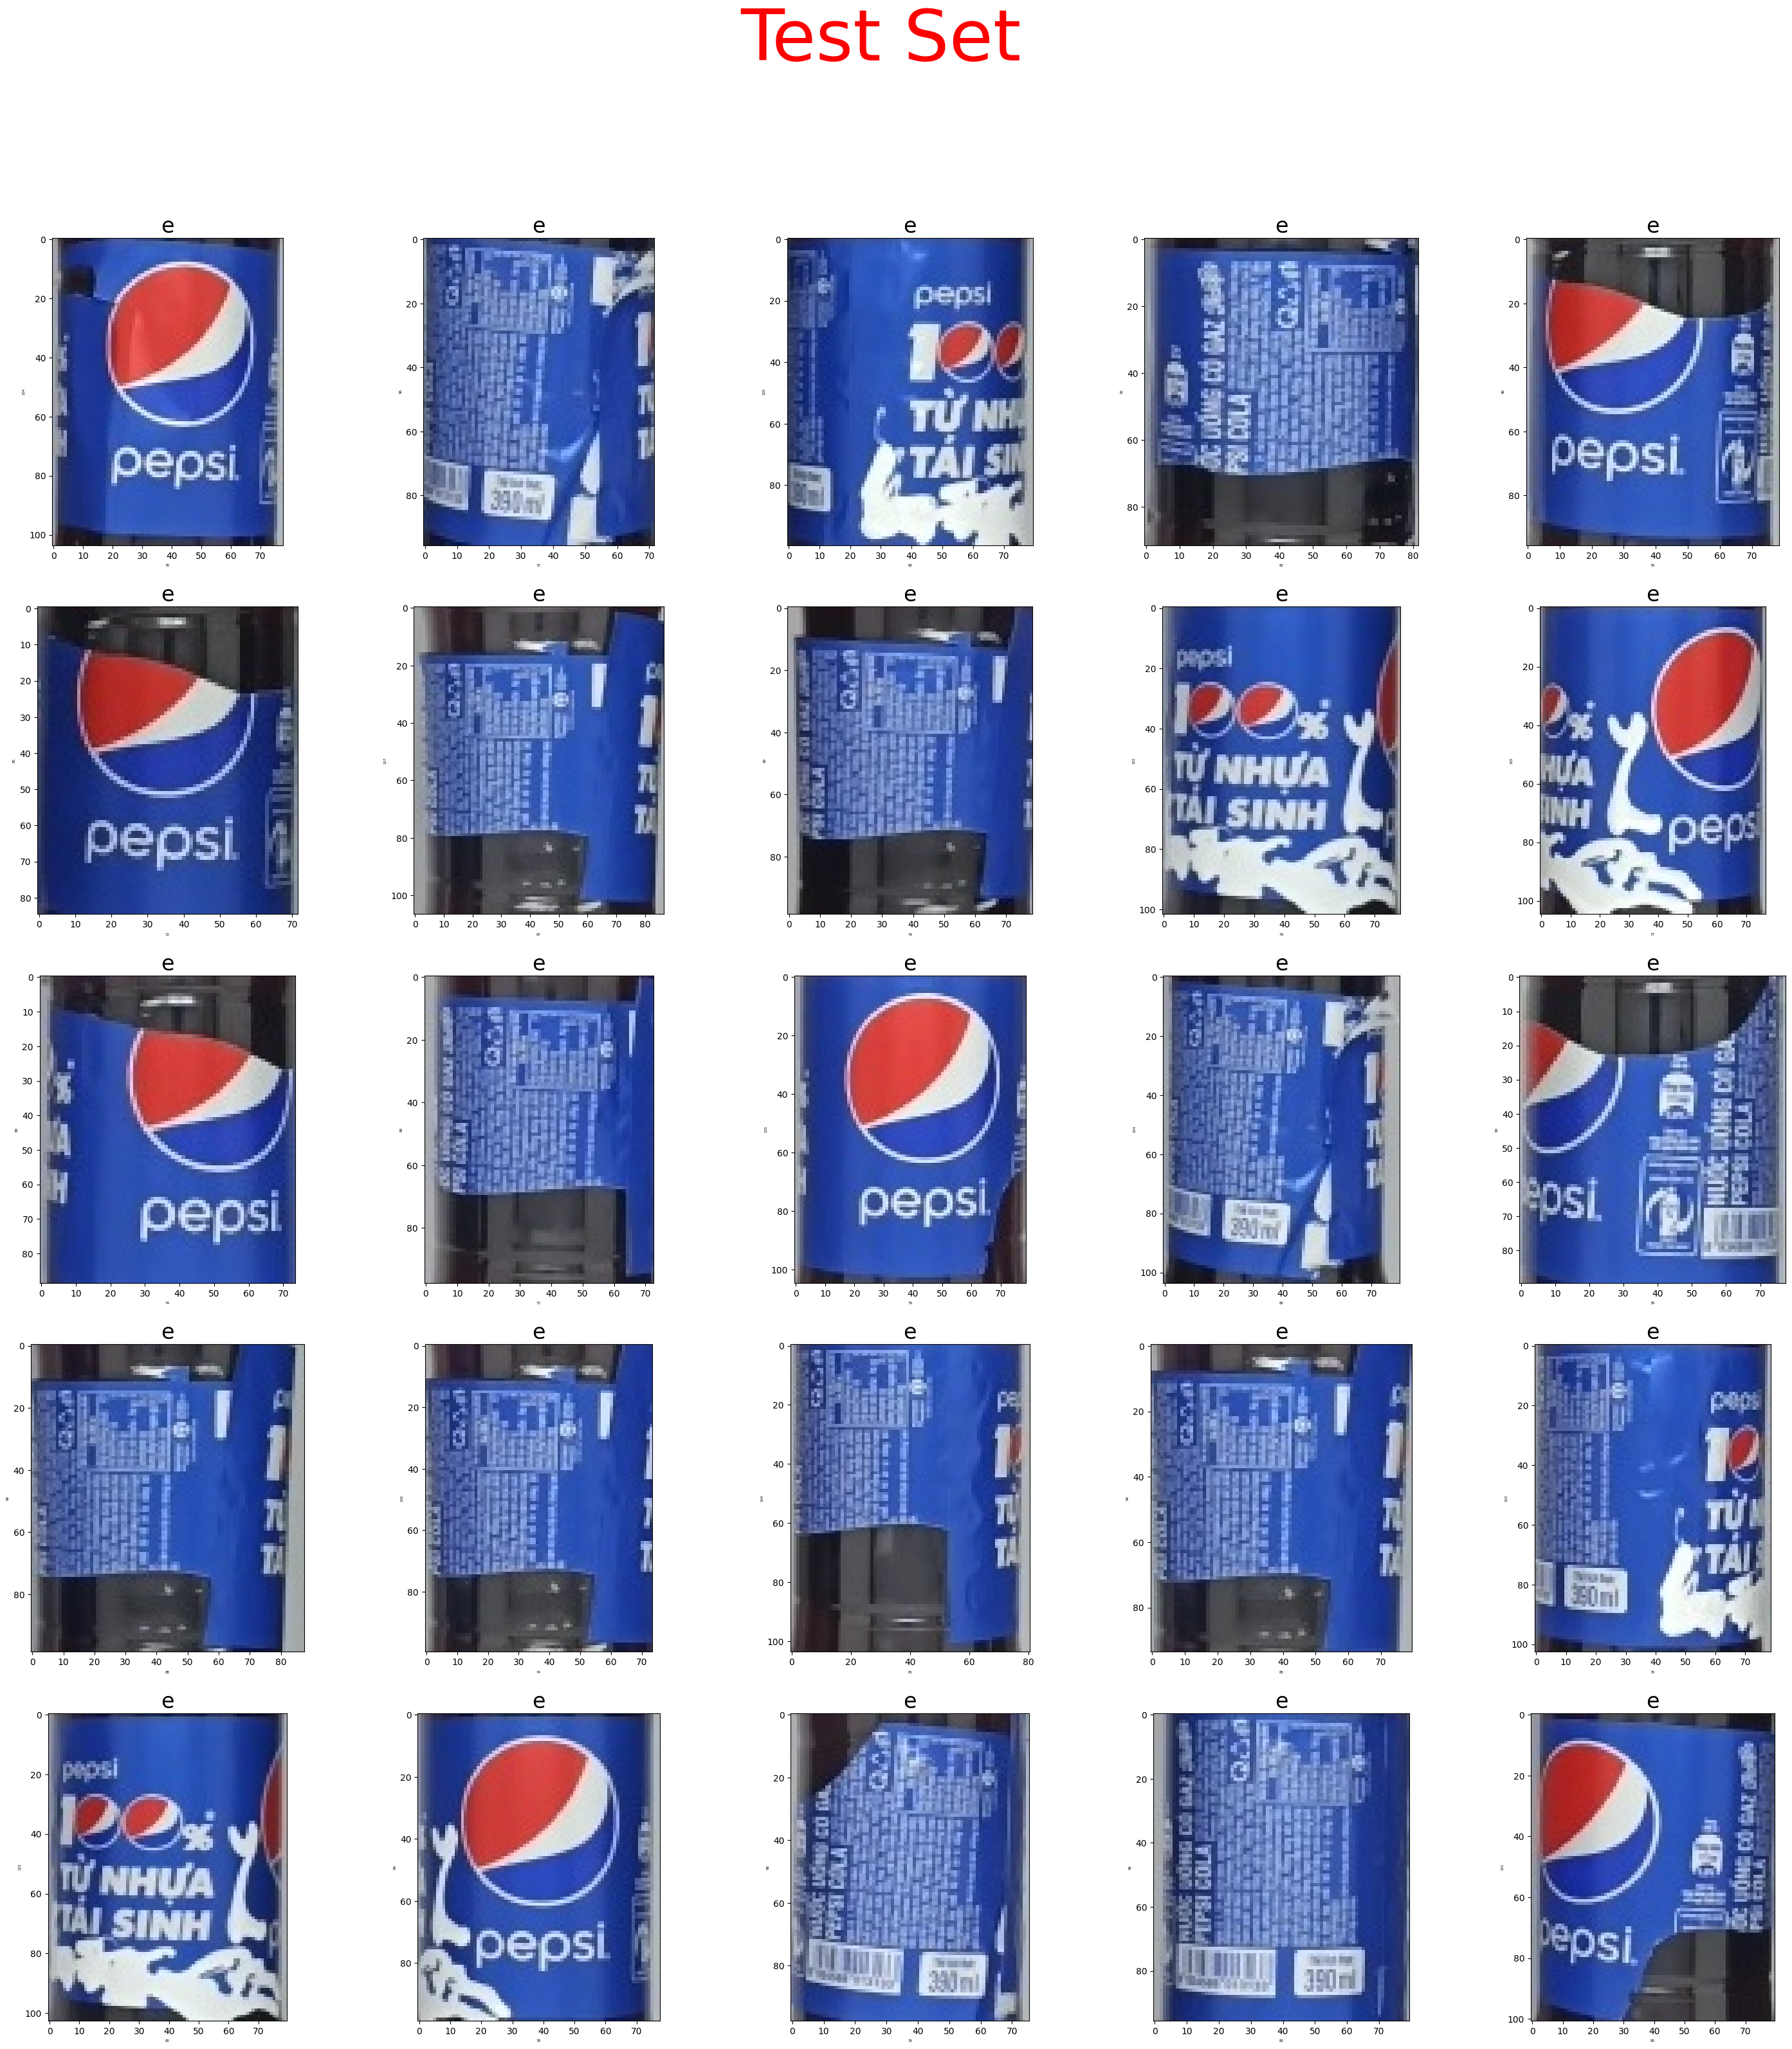

In [17]:
# Visualizing 25 images from in test data
plt.figure(figsize=(36,36))
plt.suptitle("Test Set", fontsize=80, color='red')
start_imgs = 180

test_list_file = os.listdir("/content/drive/MyDrive/DEEP/classification_data_new/test")

for i in range(1,26):
    plt.subplot(5,5,i)
    img_path = data_dir + '/test/' + test_list_file[start_imgs + i]
    _img = imread(img_path)
    plt.imshow(_img)
    plt.xlabel(_img.shape[1], fontsize = 4)#width of image
    plt.ylabel(_img.shape[0], fontsize = 4)#height of image
    plt.title(test_list_file[start_imgs + i][0],fontsize=24)

## Collecting the Training Data

In [18]:
image_data = [] #image
image_labels = [] #label: 0,1,2,...

for i in range(NUM_CATEGORIES):
    path = data_dir + '/train/' + str(i)
    images = os.listdir(path)

    for img in images:
        try:
            image = cv2.imread(path + '/' + img)
            image_fromarray = Image.fromarray(image, 'RGB')
            resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH)) #(30,30)
            image_data.append(np.array(resize_image))
            image_labels.append(i)
        except:
            print("Error in " + img)

# Changing the list to numpy array
image_data = np.array(image_data)
image_labels = np.array(image_labels)

print(image_data.shape, image_labels.shape)

(3052, 90, 90, 3) (3052,)


## Shuffling the training data

In [19]:
shuffle_indexes = np.arange(image_data.shape[0])
np.random.shuffle(shuffle_indexes)
image_data = image_data[shuffle_indexes]
image_labels = image_labels[shuffle_indexes]

## Splitting the data into train and validation set - Normalize data

In [20]:
X_train, X_val, y_train, y_val = train_test_split(image_data, image_labels, test_size=0.3, random_state=42, shuffle=True)

X_train = X_train/255
X_val = X_val/255

print("X_train.shape", X_train.shape)
print("X_valid.shape", X_val.shape)
print("y_train.shape", y_train.shape)
print("y_valid.shape", y_val.shape)

X_train.shape (2136, 90, 90, 3)
X_valid.shape (916, 90, 90, 3)
y_train.shape (2136,)
y_valid.shape (916,)


## One hot encoding the labels

In [21]:
y_train = keras.utils.to_categorical(y_train, NUM_CATEGORIES)
y_val = keras.utils.to_categorical(y_val, NUM_CATEGORIES)

print(y_train.shape)
print(y_val.shape)

(2136, 2)
(916, 2)


## Making the model

In [22]:
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', input_shape=(IMG_HEIGHT,IMG_WIDTH,channels)),
    keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),

    keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),

    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(rate=0.5),

    keras.layers.Dense(2, activation='softmax')
])

In [23]:
lr = 0.001
epochs = 30

opt = Adam(learning_rate=lr)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

## Augmenting the data and training the model

In [24]:
aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode="nearest")

history = model.fit(aug.flow(X_train, y_train, batch_size=32), epochs=epochs, validation_data=(X_val, y_val))

Epoch 1/30
67/67 [==============================] - 16s 105ms/step - loss: 0.7645 - accuracy: 0.8319 - val_loss: 1.5262 - val_accuracy: 0.5175
Epoch 2/30
67/67 [==============================] - 8s 113ms/step - loss: 0.2737 - accuracy: 0.9012 - val_loss: 4.7442 - val_accuracy: 0.5120
Epoch 3/30
67/67 [==============================] - 6s 86ms/step - loss: 0.2465 - accuracy: 0.9171 - val_loss: 5.9970 - val_accuracy: 0.5120
Epoch 4/30
67/67 [==============================] - 5s 79ms/step - loss: 0.2241 - accuracy: 0.9209 - val_loss: 5.4117 - val_accuracy: 0.5120
Epoch 5/30
67/67 [==============================] - 6s 94ms/step - loss: 0.2214 - accuracy: 0.9237 - val_loss: 5.1545 - val_accuracy: 0.5120
Epoch 6/30
67/67 [==============================] - 6s 96ms/step - loss: 0.1958 - accuracy: 0.9345 - val_loss: 4.5496 - val_accuracy: 0.5295
Epoch 7/30
67/67 [==============================] - 5s 81ms/step - loss: 0.1817 - accuracy: 0.9349 - val_loss: 3.1885 - val_accuracy: 0.5273
Epoch 8/30

## Evaluating the model

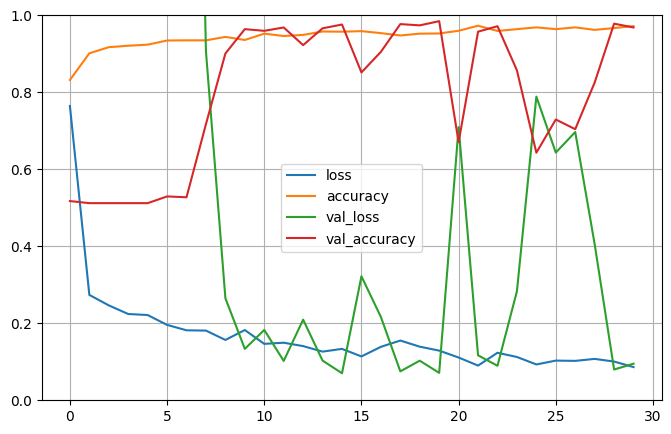

In [25]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

## Save model

In [26]:
model.save("model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Loading the test data and running the predictions

In [27]:
model = load_model("model.h5")

In [28]:
data =[]
test_list_file = os.listdir("/content/drive/MyDrive/DEEP/classification_data_new/test")
labels = []
for img in test_list_file:
    try:
        image = cv2.imread("/content/drive/MyDrive/DEEP/classification_data_new/test" + '/' +img)
        image_fromarray = Image.fromarray(image, 'RGB')
        resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
        data.append(np.array(resize_image))
        if img[0] == "g":
            labels.append(0)
        else:
            labels.append(1)
    except:
        print("Error in " + img)
X_test = np.array(data)
X_test = X_test/255

pred = model.predict(X_test)
pred_mask = [np.argmax(i) for i in pred]
# #Accuracy with the test data
print('Test Data accuracy: ',accuracy_score(labels, pred_mask)*100)

13/13 [==============================] - 1s 31ms/step
Test Data accuracy:  94.5


## Visualizing the confusion matrix

In [29]:
from sklearn.metrics import confusion_matrix
cf = confusion_matrix(labels, pred_mask)

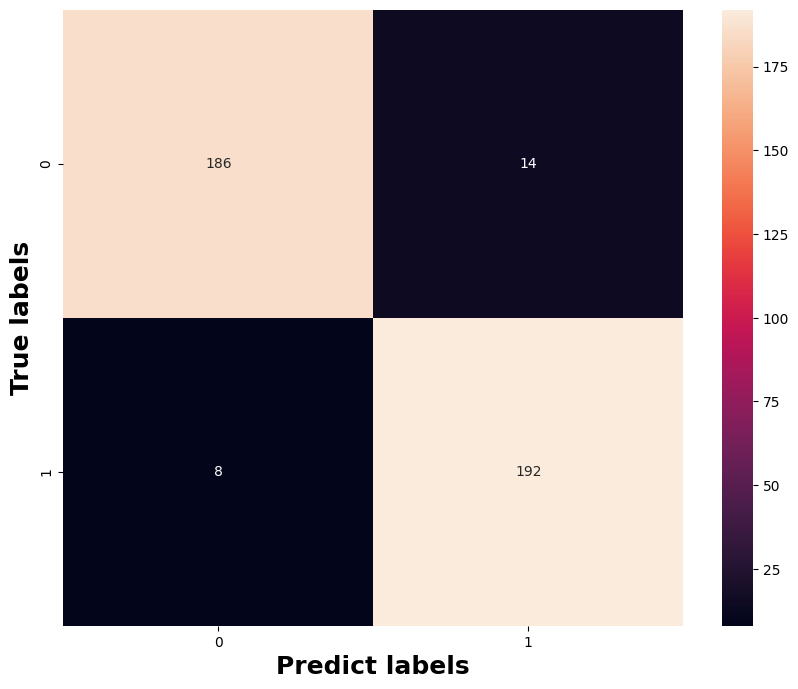

In [30]:
import seaborn as sns
df_cm = pd.DataFrame(cf, index = classes,  columns = classes)
plt.figure(figsize = (10,8))
sns.heatmap(df_cm, annot=True,fmt='d')
plt.xlabel("Predict labels",fontsize=18, fontweight='bold')
plt.ylabel("True labels",fontsize=18, fontweight='bold')
plt.show()

## Visualizing - Predictions on Test Data

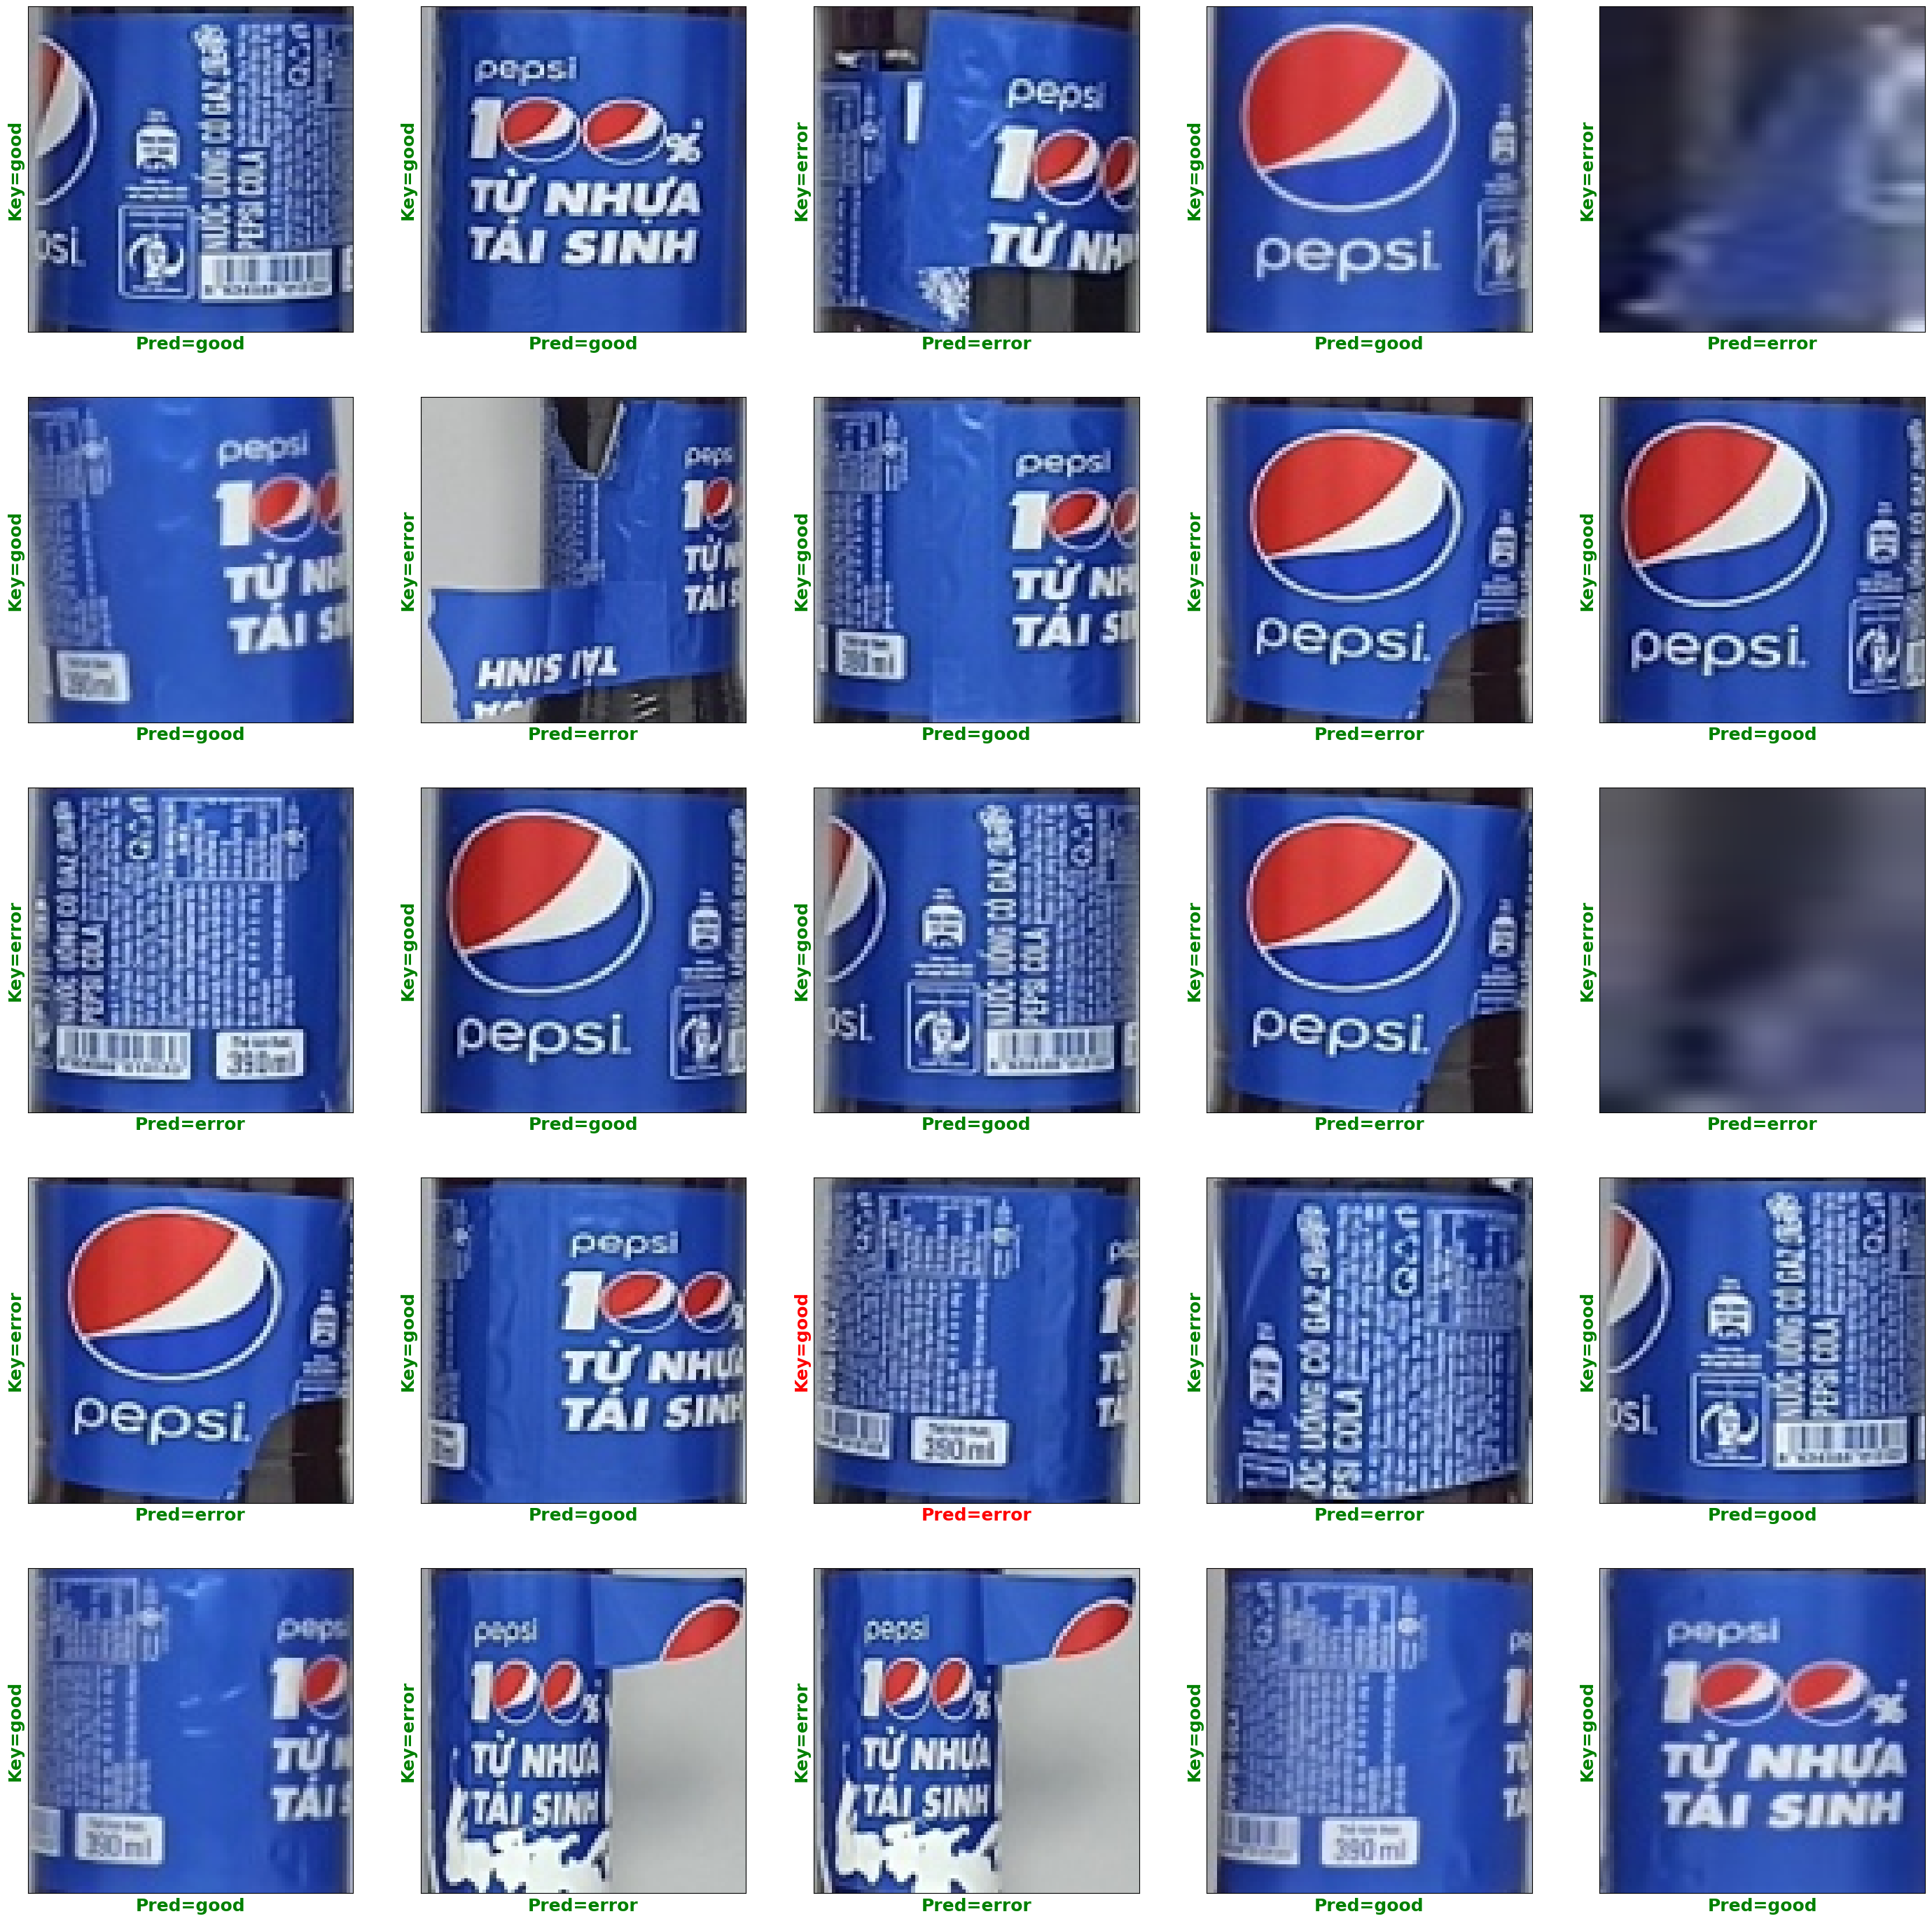

<Figure size 640x480 with 0 Axes>

In [31]:
plt.figure(figsize = (35,35))

start_index = 50
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    prediction = classes[pred_mask[start_index + i]]
    actual = classes[labels[start_index + i]]
    col = 'g'
    if prediction != actual:
        col = 'r'
    plt.xlabel('Pred={}'.format(prediction), color = col, fontweight = "bold",fontsize = 18)
    plt.ylabel('Key={}'.format(actual), color = col, fontweight = "bold",fontsize = 18)
    plt.imshow(np.flip(X_test[start_index + i], axis=-1))
plt.show()

plt.savefig("predict.png", transparent=True)